In [1]:
!pip install chess stockfish --upgrade --quiet

In [87]:
import boto3
import json
from botocore.exceptions import ClientError

br_run_client = boto3.client("bedrock-runtime", region_name="us-east-1")

#br_model_id = "arn:aws:bedrock:us-east-1:769977401909:imported-model/kfib3qiemnmr"
br_model_id = "arn:aws:bedrock:us-east-1:769977401909:imported-model/4q02n3w8s02a"

In [88]:
template = {
    "prompt": (
        "What is your next move in UCI notation. "
        "Provide only the UCI notation for your next move. Your next move should be a valid legal move only for the color you are playing.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{context}\n\n"
    ),
    "completion": " {response}",
}


In [107]:
def call_invoke_model_and_print(native_request):
    request = json.dumps(native_request)

    try:
        # Invoke the model with the request.
        response = br_run_client.invoke_model(modelId=br_model_id, body=request)
        model_response = json.loads(response["body"].read())
        #print(f"model_response: {model_response}")
        response_text = model_response['generation'].replace("\n", "")
        return response_text
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{br_model_id}'. Reason: {e}")
        exit(1)

In [104]:
def get_llm_next_move(fen_context, next_turn, illegal_move):

    instruction = '''In the FEN Lowercase letters describe the black pieces. "p" stands for pawn, "r" for rook, "n" for knight, "b" for bishop, "q" for queen, and "k" for king.
The same letters are used for the white pieces, but they appear in uppercase.
Empty squares are denoted by numbers from one to eight, depending on how many empty squares are between two pieces.
Use the FEN to understand the position of the pieces on the chessboard and recommend legal moves accordingly and follow the rules of playing chess to recommend legal moves.'''

    context = f"You are a chess grandmaster. You are playing {next_turn} color and the current chessboard FEN is {fen_context}."

    formatted_prompt = template["prompt"].format(instruction=instruction, context=context, answer="")

    # if illegal_move is not None and len(illegal_move) > 0:
    #     formatted_prompt = f"{formatted_prompt} {illegal_move} is not a valid move."

    #print(f"formatted_prompt: {formatted_prompt}")
    native_request = {
        "prompt": formatted_prompt,
        "max_tokens": 15,
        "top_p": 0.9,
        "temperature": 0.1,
        "top_k": 50,
    }
    llm_output = call_invoke_model_and_print(native_request)
    idx = llm_output.find("### Response:")+13
    llm_output = llm_output[idx:(idx+5)]
    # print(f"llm_output: {llm_output}")
    return llm_output.strip()

In [105]:
get_llm_next_move("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1", "WHITE", None)

model_response: {'generation': '### Response:\n e7e5', 'generation_token_count': 8, 'stop_reason': 'stop', 'prompt_token_count': 229}


'e7e5'

SF Move  - e2e4 | WHITE | Is Move Legal: True | FEN: rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1 | Move Count: 1
LLM Move - e7e5 | BLACK | Is Move Legal: True | FEN: rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2 | Move Count: 1
SF Move  - g1f3 | WHITE | Is Move Legal: True | FEN: rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2 | Move Count: 3
LLM Move - b8c6 | BLACK | Is Move Legal: True | FEN: r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3 | Move Count: 3
SF Move  - d2d4 | WHITE | Is Move Legal: True | FEN: r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3 | Move Count: 5
LLM Error #0: f8g7 for BLACK is illegal move!!! for r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3  | FEN: r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3
LLM Error #1: f8g7 for BLACK is illegal move!!! for r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3  | FEN: r1bqkbnr/pppp1ppp/2n5/4p3/3

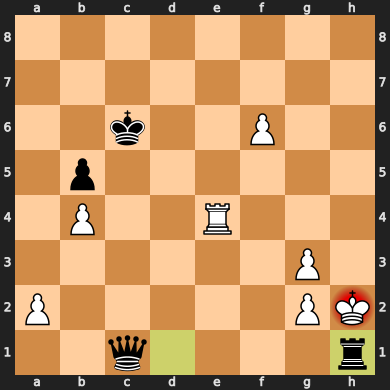

In [108]:
from stockfish import Stockfish
import chess
import chess.engine

stockfish = Stockfish(path='/home/sagemaker-user/riv2024-chess/stockfish/stockfish-ubuntu-x86-64-sse41-popcnt')
stockfish.update_engine_parameters({"Hash": 2048, "UCI_Chess960": "true"})
stockfish.set_elo_rating(1350)
fen_state = stockfish.get_fen_position()

board = chess.Board()
board.reset_board()
board.chess960 = True
stockfish.set_fen_position(board.fen())

move_count = 0
move_list = []
s = ","

while True:

    sfish_move = stockfish.get_best_move()
    try:
        move_color = 'WHITE' if board.turn else 'BLACK'
        uci_move = board.push_san(sfish_move).uci()
        stockfish.set_fen_position(board.fen())
        move_count += 1
        move_list.append(f"{sfish_move}")
        print(f'SF Move  - {sfish_move} | {move_color} | Is Move Legal: {stockfish.is_fen_valid(board.fen())} | FEN: {board.fen()} | Move Count: {move_count}')
    except (chess.InvalidMoveError, chess.IllegalMoveError) as e:
        print(f"Stockfish Error for {move_color}: {e}")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    if board.is_checkmate():
        print("Stockfish won!")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    if board.is_stalemate():
        print("Draw!")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    next_turn = 'WHITE' if board.turn else 'BLACK'
    llm_next_move = get_llm_next_move(board.fen(), next_turn, None)
    if llm_next_move is None:
        print("Failed to get a move from LLM. Ending the game.")
        break

    ill_mov_cnt = 0
    while True:
        try:
            is_llm_move_legal = True
            prev_fen = board.fen()
            uci_move = board.push_san(llm_next_move).uci()
            is_llm_move_legal = stockfish.is_fen_valid(board.fen())
            if is_llm_move_legal:
                print(f'LLM Move - {llm_next_move} | {next_turn} | Is Move Legal: {stockfish.is_fen_valid(board.fen())} | FEN: {board.fen()} | Move Count: {move_count}')
                stockfish.set_fen_position(board.fen())
                move_count += 1
                move_list.append(f"{llm_next_move}")
                break
            else:
                board.pop()
                print('Popping board and retrying LLM Next Move!!!')
                llm_next_move = get_llm_next_move(board.fen(), next_turn, llm_next_move, s.join(move_list))
        except (chess.AmbiguousMoveError, chess.IllegalMoveError, chess.InvalidMoveError) as e:
            print(f"LLM Error #{ill_mov_cnt}: {llm_next_move} for {next_turn} is illegal move!!! for {prev_fen}  | FEN: {board.fen()}")
            if ill_mov_cnt == 5:
                print(f"{ill_mov_cnt} illegal moves so far, exiting....")
                break
            ill_mov_cnt += 1
            llm_next_move = get_llm_next_move(board.fen(), next_turn, llm_next_move)

        if board.is_checkmate():
            print("LLM won!")
            print(f"### Move Count: {move_count} ###")
            print(f'Moves list - {s.join(move_list)}')
            break

        if board.is_stalemate():
            print("Draw!")
            print(f"### Move Count: {move_count} ###")
            print(f'Moves list - {s.join(move_list)}')
            break
    if move_count == 50:
        print("Played 50 moves hence quitting!!!!")
        break
board

In [735]:
print("\033c" + stockfish.get_board_visual())

c+---+---+---+---+---+---+---+---+
|   |   |   |   |   | k |   | r | 8
+---+---+---+---+---+---+---+---+
|   | p |   | n |   |   | p |   | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   | p |   |   | 6
+---+---+---+---+---+---+---+---+
| p |   | p |   |   |   |   | p | 5
+---+---+---+---+---+---+---+---+
|   |   |   |   |   | N | P |   | 4
+---+---+---+---+---+---+---+---+
|   |   |   |   |   | P |   |   | 3
+---+---+---+---+---+---+---+---+
|   | P |   | R | N |   | P |   | 2
+---+---+---+---+---+---+---+---+
|   |   |   |   | K |   |   | R | 1
+---+---+---+---+---+---+---+---+
  a   b   c   d   e   f   g   h



In [807]:
board.reset_board()
board.chess960 = True
stockfish.set_fen_position(board.fen())

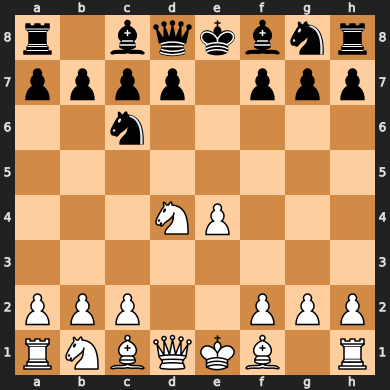

In [810]:
board.set_board_fen("r1bqkbnr/pppp1ppp/2n5/8/3NP3/8/PPP2PPP/RNBQKB1R")
board
# SF Move  - e2e4 | WHITE | Is Move Legal: True
# LLM Move - e7e5 | BLACK | Is Move Legal: True
# SF LLM Move position set
# SF Move  - g1f3 | WHITE | Is Move Legal: True
# LLM Move - b8c6 | BLACK | Is Move Legal: True
# SF LLM Move position set
# SF Move  - d2d4 | WHITE | Is Move Legal: True
# LLM Move - e5d4 | BLACK | Is Move Legal: True
# SF LLM Move position set
# SF Move  - f3d4 | WHITE | Is Move Legal: True
# LLM Error: d8d7 for BLACK is illegal move!!! 
# LLM Error: b1c3 for BLACK is illegal move!!!
# LLM Error: a8d8 for BLACK is illegal move!!!

In [797]:
print('WHITE' if board.turn else 'BLACK')
uci_move = board.push_san("e7e5").uci()

WHITE


IllegalMoveError: no matching legal move for e7e5 (e7 -> e5) in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

In [766]:
print('WHITE' if board.turn else 'BLACK')
move = chess.Move.from_uci("e5d4")
uci_move = board.push(move)

BLACK


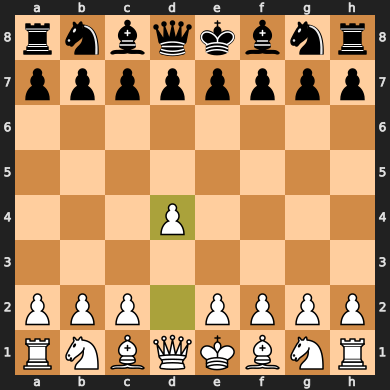

In [783]:
board